# Documentación Técnica del Pipeline ETLT
## Análisis de Potencial Energético Renovable (Solar y Eólico)

Este notebook describe el diseño, la arquitectura y las decisiones técnicas del pipeline de datos **ETLT** (Extract, Transform, Load, Transform) para el análisis del potencial energético renovable en **Riohacha** (Colombia) y la **Patagonia** (Argentina), con el objetivo de responder preguntas de negocio sobre variabilidad solar/eólica, patrones históricos y condiciones climáticas asociadas.

---

## 1. Descripción general del pipeline ETLT

### 1.1 Objetivo del proyecto

El pipeline tiene como objetivo **integrar, limpiar y transformar** datos climáticos procedentes de múltiples fuentes (APIs en tiempo real, datos históricos en JSON y datos ingeridos vía Airbyte) en un **Data Lake** sobre AWS S3, para posteriormente calcular índices de potencial energético (eólico y solar) y generar tablas analíticas que permitan responder preguntas de negocio.

### 1.2 Diseño general

- **Extract:** Ingesta de datos desde:
  - **OpenWeatherMap API** (en tiempo real vía Kafka producer, y en batch vía Airbyte hacia S3).
  - **Archivos JSON históricos** almacenados en S3 (Riohacha y Patagonia).
  - **Datos en formato Parquet** en S3 RAW, procedentes de Airbyte (Riohacha) y del consumidor Spark Streaming desde Kafka (Patagonia).

- **Transform (primera etapa):** Los datos crudos (RAW) se leen desde S3, se aplanan (estructuras anidadas de OpenWeatherMap), se estandarizan nombres y tipos, se aplican reglas de calidad y se escriben en la **capa Silver** en formato Parquet particionado (año/mes/día de ingestión).

- **Load (intermedio):** Los datos Silver se almacenan en un bucket S3 dedicado, listos para consumo por la siguiente etapa.

- **Transform (segunda etapa):** Sobre la capa Silver se calculan los **índices de potencial energético** (WPI: Wind Potential Index, SPI: Solar Potential Index), se agregan por día (resumen diario) y por hora/mes (patrones horarios y mensuales), y se escriben en la **capa Gold**.

### 1.3 Orquestación

**Apache Airflow** orquesta la ejecución de los jobs Spark (capa Silver y capa Gold) en secuencia, con una frecuencia configurada (por ejemplo, cada 12 horas), garantizando que Gold se ejecute solo tras el éxito de Silver.

---

## 2. Diagrama de arquitectura del pipeline

A continuación se presenta un diagrama que especifica las **fuentes de datos**, las **herramientas** utilizadas en cada etapa y el **flujo completo** de los datos.

### Diagrama de arquitectura

A continuación se muestra el diagrama que especifica las fuentes de datos, las herramientas y el flujo completo del pipeline ETLT.

![Diagrama de arquitectura del pipeline ETLT](Diagrama ELTL.png)

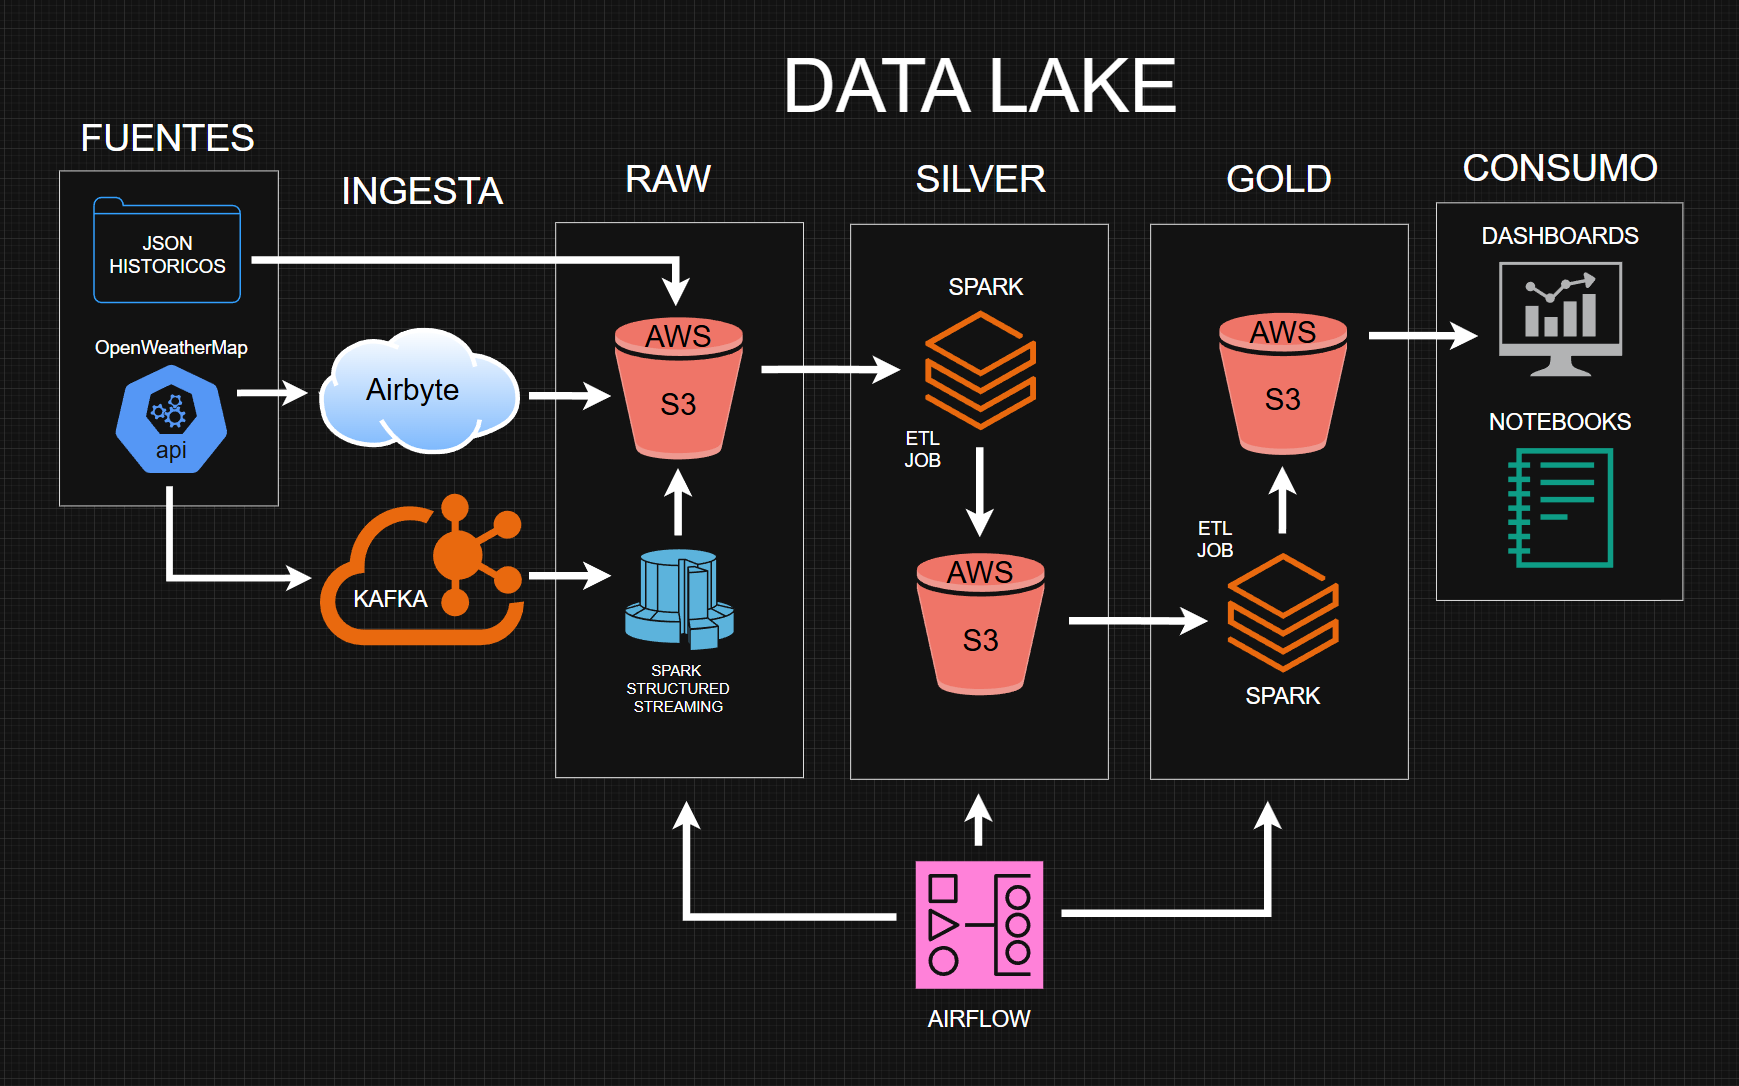

In [3]:
# Visualización del diagrama (imagen en la misma carpeta)
from IPython.display import Image, display

display(Image(filename="Diagrama ELTL.png"))

### Resumen del flujo de datos

| Etapa | Herramienta | Función | Salida |
|-------|-------------|--------|--------|
| Ingesta tiempo real | Kafka + Producer (Python) | Consumir API OpenWeatherMap y publicar en topic | Mensajes en `openweather_topic` |
| Ingesta streaming | Spark Structured Streaming (consumer) | Leer Kafka, particionar y escribir en S3 | Parquet en S3 RAW (Patagonia) |
| Ingesta batch | Airbyte | Conectar OpenWeatherMap y escribir en S3 | Parquet en S3 RAW (Riohacha) |
| Datos históricos | — | Archivos JSON en S3 RAW | `Riohacha_11_538415.json`, `Patagonia_-41.json` |
| ETL Silver | Apache Spark (capa_silver.py) | Limpieza, aplanado, estandarización, calidad | Parquet particionado en S3 SILVER |
| ETL Gold | Apache Spark (capa_gold.py) | WPI, SPI, agregaciones diarias y por hora/mes | Parquet en S3 GOLD (resumen_diario, patrones_horarios) |
| Orquestación | Apache Airflow | Programar y ejecutar Silver → Gold | DAG `spark_etl_final` (cada 12 h) |

---

## 3. Propósito de cada capa del Data Lake

El Data Lake se organiza en **tres capas** (RAW, Silver, Gold). Cada una tiene un propósito explícito y un rol justificado dentro del flujo de procesamiento.

### 3.1 Capa RAW (Bronze)

**Propósito:** Almacenar los datos tal como llegan de las fuentes, **sin transformaciones de negocio**, para garantizar trazabilidad, reprocesamiento y auditoría.

**Contenido típico:**
- Carpetas por fuente: `raw/openweather-api/RiohachaOpen_Riohacha/`, `raw/openweather-api/PatagoniaopenWeather/` (Parquet).
- Archivos históricos: `datos-historicos/Riohacha_11_538415.json`, `datos-historicos/Patagonia_-41.json`.

**Justificación:** Permite re-ejecutar el pipeline desde el origen ante cambios en las transformaciones Silver/Gold, evita pérdida de datos por errores en etapas posteriores y cumple con el principio de "ingesta primero, transformar después".

---

### 3.2 Capa Silver

**Propósito:** Contener datos **limpios, estandarizados y listos para análisis**, con un esquema unificado independiente del formato de origen (JSON anidado vs plano).

**Transformaciones aplicadas:**
- Aplanamiento de estructuras anidadas (main, wind, coord, weather, rain, snow, clouds).
- Estandarización de nombres (ej. `temp_c` → `temperatura_c`, `wind_speed` → `velocidad_viento_m_s`).
- Tipos de dato consistentes (LongType para timestamps, DoubleType para métricas).
- Validación de calidad: filtrado de registros con ciudad, temperatura o timestamp nulos.
- Particionado por fecha de ingestión (ingestion_year, ingestion_month, ingestion_day).

**Justificación:** Centraliza la lógica de limpieza y esquema en un solo lugar; las etapas posteriores (Gold, reportes) consumen solo Silver, reduciendo complejidad y duplicación. Facilita la unión de datos de múltiples fuentes (Riohacha, Patagonia, histórico vs reciente) en un único dataset coherente.

---

### 3.3 Capa Gold

**Propósito:** Ofrecer **métricas de negocio y agregaciones** listas para reporting, dashboards y respuestas a preguntas analíticas (potencial solar/eólico, resúmenes diarios, patrones horarios y mensuales).

**Contenido:**
- **Resumen diario** (`gold/resumen_clima_diario/`): por ciudad y fecha, promedios y máximos de potencial eólico/solar, temperaturas, humedad, precipitación, nubosidad, etc.
- **Patrones horarios** (`gold/patrones_horarios/`): por ciudad, mes-año y hora, promedios de potencial eólico/solar y variables climáticas, para analizar variación a lo largo del día y del mes.

**Cálculos clave:**
- **WPI (Wind Potential Index):** proporcional a velocidad del viento³, normalizado (÷100).
- **SPI (Solar Potential Index):** índice UV atenuado por nubosidad (factor_nubes = 1 - nubes%/100).

**Justificación:** La capa Gold responde directamente a las preguntas de negocio (variación diaria/mensual, días de mayor/menor potencial, condiciones asociadas a reducciones). Evita que los usuarios finales o las herramientas de BI tengan que recalcular agregaciones o índices; el costo de cómputo se paga una vez en el pipeline.

---

## 4. Stack tecnológico: selección y justificación

La elección del stack se basa en **escalabilidad**, **facilidad de integración**, **rendimiento** y **adecuación al problema** (datos climáticos, múltiples fuentes, agregaciones pesadas y necesidad de orquestación).

| Componente | Tecnología | Justificación |
|------------|------------|---------------|
| **Almacenamiento** | AWS S3 | Escalabilidad ilimitada, bajo costo, integración nativa con Spark (s3a), Airbyte y Kafka consumers. Ideal para Data Lake. |
| **Procesamiento batch** | Apache Spark (PySpark) | Procesamiento distribuido sobre grandes volúmenes (JSON + Parquet), soporte nativo para Parquet y particionado, expresividad en transformaciones (SQL + Python). Escala horizontalmente. |
| **Streaming (opcional)** | Kafka + Spark Structured Streaming | Desacopla la ingesta en tiempo real de la API del procesamiento; permite escribir en S3 en micro-batches (ej. cada 24 h) con checkpoint para exact-once. |
| **Orquestación** | Apache Airflow | Programación y dependencias (Silver → Gold), reintentos, monitoreo vía UI. Ejecución remota de jobs Spark vía SSH. |
| **Ingesta SaaS** | Airbyte | Conexiones managed a OpenWeatherMap y S3 sin código custom para Riohacha; reduce mantenimiento de conectores propios. |
| **Mensajería** | Apache Kafka | Buffer de eventos en tiempo real, desacoplamiento producer/consumer, persistencia de mensajes. |
| **Contenedores** | Docker / Docker Compose | Entorno reproducible para Spark, Kafka y Airflow en instancias EC2; despliegue consistente entre entornos. |

### Criterios aplicados

- **Escalabilidad:** Spark y S3 escalan con el volumen de datos; Kafka con particiones y brokers.
- **Integración:** S3 como punto central (Airbyte, Spark, Kafka consumer escriben/leen desde el mismo Data Lake).
- **Rendimiento:** Parquet columnar y particionado reduce I/O; configuración de shuffle y memoria en Spark (ej. 100 particiones, 4g executor) adaptada a cargas pesadas de agregación.
- **Adecuación al problema:** Índices WPI/SPI y agregaciones por día y hora/mes están alineados con las preguntas de variación temporal y patrones históricos en dos ubicaciones geográficas.

---

## 5. Fuentes de datos y preguntas de negocio

A continuación se identifican las **fuentes de datos** utilizadas en el pipeline y se evalúa su **relevancia y valor analítico** respecto a cada **pregunta de negocio**.

### 5.1 Preguntas de negocio (objetivos del análisis)

1. ¿Cómo varía el **potencial solar estimado** a lo largo del día y del mes en Riohacha y en la Patagonia?
2. ¿Qué **patrones históricos** se observan en el **potencial eólico** de ambas ubicaciones?
3. ¿Qué **condiciones climáticas** están asociadas con **reducciones significativas** en el potencial renovable?
4. ¿Cómo se comportan las **predicciones meteorológicas** en comparación con las **condiciones observadas** en el pasado reciente?
5. ¿Cuáles fueron los **días con mayor y menor potencial energético** en cada ubicación durante el periodo de análisis?

### 5.2 Fuentes de datos disponibles

| Fuente | Tipo | Ubicaciones | Variables clave | Formato en RAW |
|--------|------|-------------|-----------------|----------------|
| **OpenWeatherMap API** (vía Airbyte) | Tiempo real / histórico reciente | Riohacha | temp, humidity, pressure, wind (speed, deg), clouds, rain, snow, weather, coord, dt | Parquet en S3 |
| **OpenWeatherMap API** (vía Kafka + Spark Streaming) | Tiempo real | Patagonia | temp_c, humidity, pressure, wind_speed, lat, lon, ts, datetime_utc | Parquet en S3 |
| **Datos históricos JSON** | Histórico | Riohacha, Patagonia | Esquema compatible (ts/temp_c, wind_speed, etc.) | JSON en S3 |

**Variables utilizadas para índices y análisis:**
- **Potencial solar (SPI):** `indice_uv` (o valor por defecto), `nubes_porcentaje`.
- **Potencial eólico (WPI):** `velocidad_viento_m_s`.
- **Condiciones climáticas:** temperatura, humedad, precipitación (lluvia_1h_mm, nieve_1h_mm), nubosidad, descripción del clima.
- **Tiempo:** timestamp (dt), ciudad, para particionado y agregaciones por día/hora/mes.

### 5.3 Matriz: Fuentes de datos vs preguntas de negocio

| Pregunta de negocio | Fuente(s) que la responden | Relevancia y valor analítico |
|---------------------|----------------------------|------------------------------|
| **1. Variación del potencial solar a lo largo del día y del mes (Riohacha y Patagonia)** | Silver + Gold (patrones_horarios); campos: indice_uv, nubes_porcentaje → SPI por hora/mes | **Alta.** La tabla `patrones_horarios` agrega por ciudad, mes y hora; el SPI captura la variación solar. Los datos históricos y recientes (OpenWeatherMap) aportan cobertura temporal. |
| **2. Patrones históricos del potencial eólico en ambas ubicaciones** | Silver + Gold (patrones_horarios y resumen_clima_diario); campo velocidad_viento_m_s → WPI | **Alta.** WPI y promedios por hora/mes y por día permiten ver estacionalidad y patrones diarios. Las dos ubicaciones (Riohacha, Patagonia) están explícitas en `ciudad`. |
| **3. Condiciones climáticas asociadas a reducciones significativas en el potencial renovable** | Silver + Gold; campos: nubes_porcentaje, lluvia_1h_mm, nieve_1h_mm, clima_descripcion_*, temperatura, humedad | **Alta.** La capa Silver conserva variables climáticas; Gold agrega precipitación total diaria, promedios de nubes y humedad. Cruce con días de bajo SPI/WPI permite identificar condiciones (tormentas, nubosidad alta, etc.). |
| **4. Predicciones vs condiciones observadas en el pasado reciente** | Requiere datos de **pronóstico** (API de forecast) y **observados** (actual/histórico) | **Media.** El pipeline actual se basa en datos **observados** (current weather + histórico). Para comparar predicciones vs observado hace falta integrar la API de forecast de OpenWeatherMap (u otra) y alinear fechas. Las fuentes actuales permiten caracterizar el “pasado reciente” y sentar la base para ese contraste. |
| **5. Días con mayor y menor potencial energético por ubicación** | Gold (resumen_clima_diario); campos: promedio_potencial_eolico_diario, max_potencial_eolico_diario, promedio_potencial_solar_diario, max_potencial_solar_diario | **Alta.** La tabla está particionada por ciudad y contiene agregados diarios; consultas por orden (TOP/BOTTOM) sobre estos campos responden directamente la pregunta. |

### 5.4 Resumen y recomendaciones

- Las fuentes actuales (OpenWeatherMap vía Airbyte/Kafka + JSON histórico) son **suficientes y relevantes** para las preguntas 1, 2, 3 y 5, gracias a las tablas Gold (resumen diario y patrones horarios) y a los índices WPI/SPI.
- Para la **pregunta 4** (predicciones vs observado) se recomienda **añadir una fuente de predicción** (ej. OpenWeatherMap Forecast API) y una capa o tabla que almacene pronósticos con fecha de predicción y fecha de validez, para poder comparar con los datos observados ya disponibles en Silver/Gold.

In [2]:
# Resumen ejecutivo: tablas Gold y su uso para las preguntas de negocio
resumen = {
    "resumen_clima_diario": {
        "uso": "Días con mayor/menor potencial (pregunta 5); condiciones diarias para cruce con reducciones (pregunta 3)",
        "particionado": "ciudad",
    },
    "patrones_horarios": {
        "uso": "Variación solar/eólica a lo largo del día y del mes (preguntas 1 y 2); patrones históricos",
        "particionado": "ciudad, mes_anio",
    },
}
for tabla, info in resumen.items():
    print(f"Tabla: {tabla}")
    print(f"  Uso: {info['uso']}")
    print(f"  Particionado: {info['particionado']}")
    print()

Tabla: resumen_clima_diario
  Uso: Días con mayor/menor potencial (pregunta 5); condiciones diarias para cruce con reducciones (pregunta 3)
  Particionado: ciudad

Tabla: patrones_horarios
  Uso: Variación solar/eólica a lo largo del día y del mes (preguntas 1 y 2); patrones históricos
  Particionado: ciudad, mes_anio

